### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'CTNNB1'
metric = 'aupr'
nz_cutoff = 5.0

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,CTNNB1,LIHC,0.05,42,0,146
1,CTNNB1,LIHC,0.05,42,1,585
2,CTNNB1,LIHC,0.05,42,2,28
3,CTNNB1,LIHC,0.05,42,3,248
4,CTNNB1,LIHC,0.0005,42,0,7259


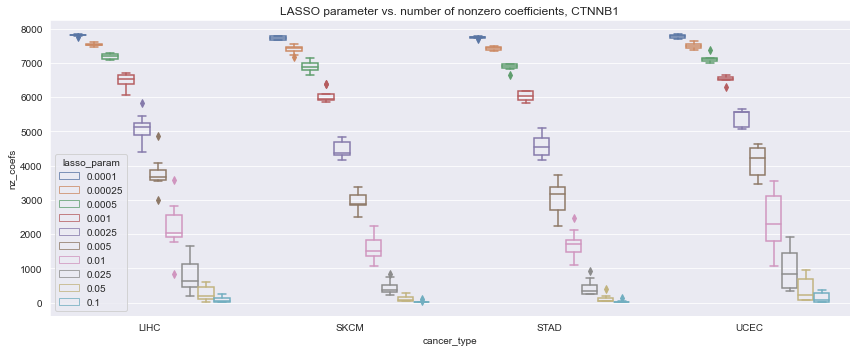

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# also fix the legend to color the edges rather than fill
for legpatch in ax.legend_.get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset,
                                                 gene=plot_gene)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,CTNNB1,STAD,signal,42,train,0,all_other_cancers,0.00025
1,0.94239,0.52137,CTNNB1,STAD,signal,42,test,0,all_other_cancers,0.00025
2,0.87474,0.69197,CTNNB1,STAD,signal,42,cv,0,all_other_cancers,0.00025
3,1.00000,1.00000,CTNNB1,STAD,signal,42,train,1,all_other_cancers,0.00025
4,0.51266,0.16999,CTNNB1,STAD,signal,42,test,1,all_other_cancers,0.00025


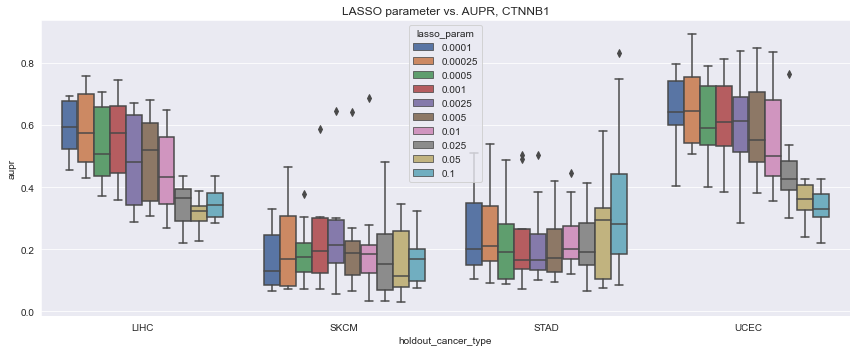

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

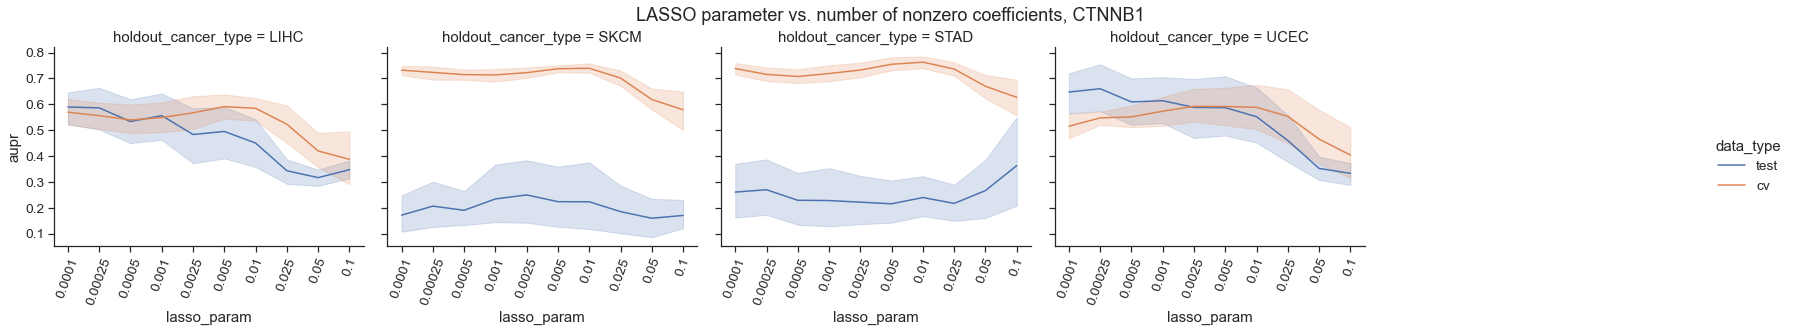

In [7]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal') &
            (perf_df.data_type.isin(['cv', 'test']))]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        kind='line', col='holdout_cancer_type',
        col_wrap=5, height=4, aspect=1.2
    )
    g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}', y=1.025)

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Compare feature selection with performance

In [8]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,CTNNB1,LIHC,0.05,42,0,146,0.92161,0.66121,train,all_other_cancers
1,CTNNB1,LIHC,0.05,42,0,146,0.45743,0.22776,test,all_other_cancers
2,CTNNB1,LIHC,0.05,42,0,146,0.77832,0.47246,cv,all_other_cancers
3,CTNNB1,LIHC,0.05,42,1,585,0.88068,0.46311,train,all_other_cancers
4,CTNNB1,LIHC,0.05,42,1,585,0.34375,0.29442,test,all_other_cancers


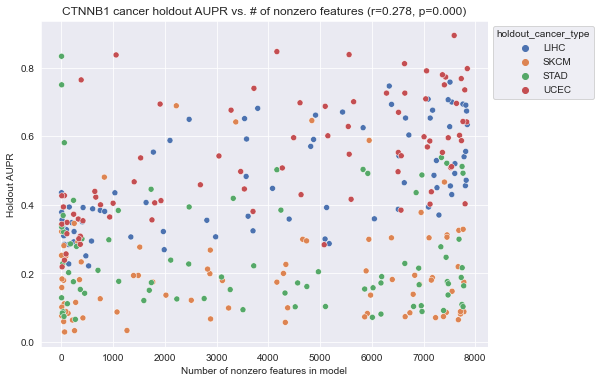

In [9]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[coefs_perf_df.data_type == 'test']
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf.png',
                dpi=200, bbox_inches='tight')

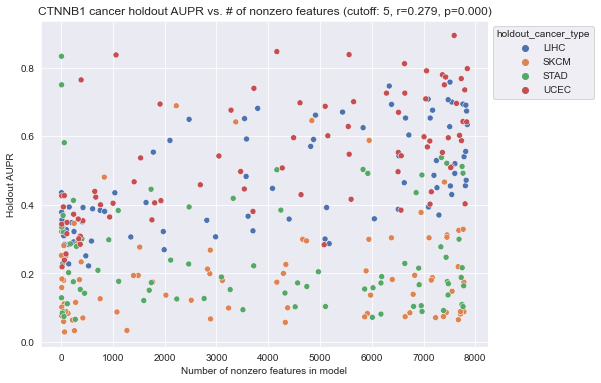

In [10]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[(coefs_perf_df.data_type == 'test') &
                  (coefs_perf_df.nz_coefs > nz_cutoff)]
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (cutoff: {nz_cutoff:.0f}, r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf.png',
                dpi=200, bbox_inches='tight')

In [11]:
# look at correlation for each cancer type individually
# positive correlation => more features, better performance
corr_cancer_type_df = []

for cancer_type in coefs_perf_df.holdout_cancer_type.unique():
    corr_df = coefs_perf_df[
        (coefs_perf_df.holdout_cancer_type == cancer_type) &
        (coefs_perf_df.data_type == 'test')
    ]
    r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)
    corr_cancer_type_df.append(
        [plot_gene, cancer_type, r, p]
    )
    
corr_cancer_type_df = pd.DataFrame(
    corr_cancer_type_df,
    columns=['gene', 'cancer_type', 'pearson_r', 'pearson_pval']
).sort_values(by='pearson_r', ascending=False)

corr_cancer_type_df

,gene,cancer_type,pearson_r,pearson_pval
0,CTNNB1,LIHC,0.648503,7.813500e-11
2,CTNNB1,UCEC,0.600678,3.856195e-09
3,CTNNB1,SKCM,0.087545,4.400038e-01
1,CTNNB1,STAD,-0.083478,4.616168e-01


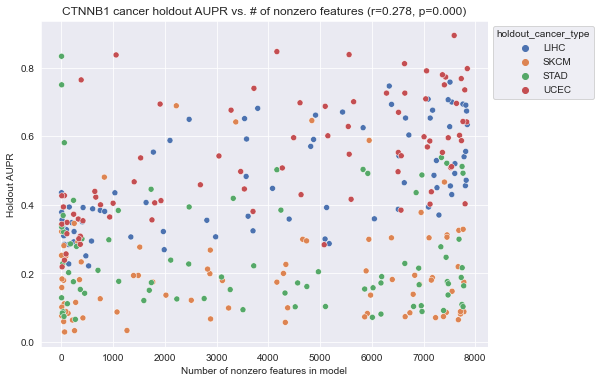

In [12]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

top_cancers = corr_cancer_type_df.cancer_type.values[:5]
    
plot_df = (
    coefs_perf_df[(coefs_perf_df.holdout_cancer_type.isin(top_cancers)) &
                  (coefs_perf_df.data_type == 'test')]
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf_top_cancers.png',
                dpi=200, bbox_inches='tight')

In [13]:
coefs_perf_pivot_df = coefs_perf_df.pivot(
    index=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param', 'nz_coefs'],
    columns='data_type',
    values=['auroc', 'aupr']
)
coefs_perf_pivot_df.columns = ['_'.join(col).strip() for col in coefs_perf_pivot_df.columns.values]
coefs_perf_pivot_df.reset_index(inplace=True)

coefs_perf_pivot_df

,gene,holdout_cancer_type,seed,fold,lasso_param,nz_coefs,auroc_cv,auroc_test,auroc_train,aupr_cv,aupr_test,aupr_train
0,CTNNB1,LIHC,1,0,0.0001,7823,0.82485,0.72523,1.00000,0.53751,0.47175,1.00000
1,CTNNB1,LIHC,1,0,0.00025,7545,0.83566,0.67957,1.00000,0.57721,0.43002,1.00000
2,CTNNB1,LIHC,1,0,0.0005,7297,0.84089,0.66409,1.00000,0.57737,0.37034,1.00000
3,CTNNB1,LIHC,1,0,0.001,6627,0.84585,0.68344,0.99974,0.53436,0.46449,0.99828
4,CTNNB1,LIHC,1,0,0.0025,5177,0.84420,0.60294,0.99844,0.54123,0.28697,0.98855
...,...,...,...,...,...,...,...,...,...,...,...,...
315,CTNNB1,UCEC,42,3,0.005,4490,0.84338,0.82738,0.99402,0.60337,0.59580,0.93470
316,CTNNB1,UCEC,42,3,0.01,3047,0.86197,0.79978,0.99079,0.62618,0.54254,0.91263
317,CTNNB1,UCEC,42,3,0.025,1409,0.84892,0.72673,0.96910,0.63553,0.46719,0.81867
318,CTNNB1,UCEC,42,3,0.05,668,0.83695,0.70292,0.93240,0.64333,0.42257,0.74800


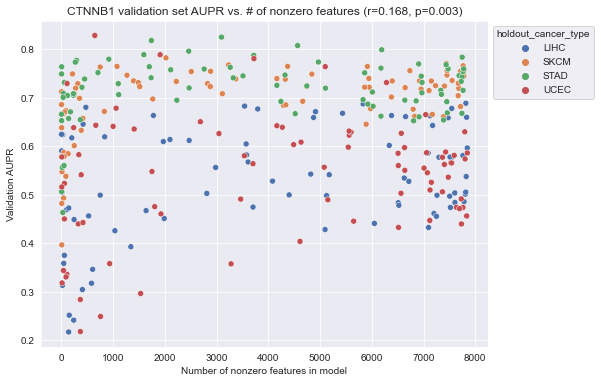

In [14]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.aupr_cv.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='aupr_cv', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} validation set AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Validation AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_validation_perf.png',
                dpi=200, bbox_inches='tight')

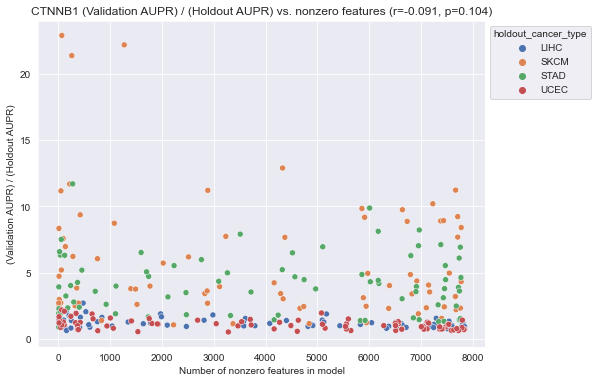

In [15]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

coefs_perf_pivot_df['cv_test_aupr_ratio'] = (
    coefs_perf_pivot_df['aupr_cv']/ coefs_perf_pivot_df['aupr_test']
)
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.cv_test_aupr_ratio.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='cv_test_aupr_ratio', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} (Validation AUPR) / (Holdout AUPR) vs. nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('(Validation AUPR) / (Holdout AUPR)')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_perf_ratio.png',
                dpi=200, bbox_inches='tight')

For this limited set of genes/cancer types, there doesn't seem to be much of a relationship between model size and "performance", for any of these three ways of defining performance.

A better way to explore correlation between model size and performance might be to look at the partial correlation while controlling for cancer type - we'll explore this in the future.